In [41]:
import unicodedata
import re
import numpy as np
import os
import io
import time

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.data import Dataset
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Embedding, GRU, Dense
from tensorflow.keras.activations import tanh, softmax
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

In [42]:
TXT_FILE = "EN-SP.txt"

In [43]:
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
                    if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())

    # Creating a space between a word and the punctuation following it
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    # Replacing everything with space except (a-z, A-Z, "?", ".", "!", ",", "¿")
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
    w = w.strip()

    # Adding a start and an end token to the sentence
    w = '<start> ' + w + ' <end>'
    return w

In [44]:
# Remove the accents, clean the sentences
# Return word pairs in the format: [ENGLISH, SPANISH]
def create_dataset(path, size):
    lines = io.open(path, encoding='UTF-8').read().strip().split('\n')
    word_pairs = [[preprocess_sentence(w) for w in line.split('\t')]
                for line in lines[:size]]
    return zip(*word_pairs)

In [45]:
en, sp = create_dataset(TXT_FILE, None)
print(en[-1])
print(sp[-1])

<start> if you want to sound like a native speaker , you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo . <end>
<start> si quieres sonar como un hablante nativo , debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un musico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado . <end>


In [46]:
def tokenize(lang):
  lang_tokenizer = Tokenizer(filters='')
  lang_tokenizer.fit_on_texts(lang)

  tensor = lang_tokenizer.texts_to_sequences(lang)
  tensor = pad_sequences(tensor, padding='post')

  return tensor, lang_tokenizer

In [47]:
def load_dataset(path, size=None):
  targ_lang, inp_lang = create_dataset(path, size)

  input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
  target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

  return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [48]:
# Limit the size of dataset
num_examples = 30000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(TXT_FILE,
                                                                num_examples)

max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

In [49]:
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

24000 24000 6000 6000


In [50]:
def convert(lang, tensor):
  for t in tensor:
    if t != 0:
      print(f'{t} ----> {lang.index_word[t]}')

In [51]:
print("Input Language; Index to Word Mapping")
convert(inp_lang, input_tensor_train[0])
print()
print("Target Language; Index to Word Mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; Index to Word Mapping
1 ----> <start>
25 ----> ella
474 ----> levanto
13 ----> la
246 ----> mano
3 ----> .
2 ----> <end>

Target Language; Index to Word Mapping
1 ----> <start>
27 ----> she
1084 ----> raised
68 ----> her
354 ----> hand
3 ----> .
2 ----> <end>


In [52]:
# Creating a tf.data Dataset
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train) // BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index) + 1
vocab_tar_size = len(targ_lang.word_index) + 1

dataset = Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [53]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 16]), TensorShape([64, 11]))

In [54]:
class Encoder(Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = Embedding(vocab_size, embedding_dim)
    self.gru = GRU(self.enc_units,
                   return_sequences=True,
                   return_state=True,
                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state=hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [55]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)

print('Encoder Output Shape: (batch_size, sequence_length, units)', sample_output.shape)
print('Encoder Hidden State Shape: (batch_size, units)', sample_hidden.shape)

Encoder Output Shape: (batch_size, sequence_length, units) (64, 16, 1024)
Encoder Hidden State Shape: (batch_size, units) (64, 1024)


In [56]:
class BahdanauAttention(Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = Dense(units)
    self.W2 = Dense(units)
    self.V = Dense(1)

  def call(self, query, values):
    query_with_time_axis = tf.expand_dims(query, 1)
    score = self.V(tanh(self.W1(query_with_time_axis) + self.W2(values)))
    attention_weights = softmax(score, axis=1)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [57]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention Result Shape: (batch_size, units)", attention_result.shape)
print("Attention Weights Shape: (batch_size, sequence_length, 1)", attention_weights.shape)

Attention Result Shape: (batch_size, units) (64, 1024)
Attention Weights Shape: (batch_size, sequence_length, 1) (64, 16, 1)


In [58]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = Embedding(vocab_size, embedding_dim)
    self.gru = GRU(self.dec_units,
                   return_sequences=True,
                   return_state=True,
                   recurrent_initializer='glorot_uniform')
    self.fc = Dense(vocab_size)
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    context_vector, attention_weights = self.attention(hidden, enc_output)
    x = self.embedding(x)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
    output, state = self.gru(x)
    output = tf.reshape(output, (-1, output.shape[2]))
    x = self.fc(output)
    return x, state, attention_weights

In [59]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)
sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print('Decoder Output Shape: (batch_size, vocab_size)', sample_decoder_output.shape)

Decoder Output Shape: (batch_size, vocab_size) (64, 4935)


In [60]:
optimizer = Adam()
loss_object = SparseCategoricalCrossentropy(from_logits=True,
                                            reduction='none')

def loss_function(real, pred):
  mask = tf.math.not_equal(real, 0)
  loss_ = loss_object(real, pred)
  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  return tf.reduce_mean(loss_)

In [61]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [62]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0
  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)
    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    for t in range(1, targ.shape[1]):
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
      loss += loss_function(targ[:, t], predictions)
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))
  variables = encoder.trainable_variables + decoder.trainable_variables
  gradients = tape.gradient(loss, variables)
  optimizer.apply_gradients(zip(gradients, variables))
  return batch_loss

In [63]:
EPOCHS = 10

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0
  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print(f'Epoch {epoch+1} Batch {batch} Loss {batch_loss.numpy():.4f}')
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix=checkpoint_prefix)

  print(f'Epoch {epoch+1} Loss {total_loss/steps_per_epoch:.4f}')
  print(f'Time taken for 1 Epoch {time.time()-start:.2f}s\n')

Epoch 1 Batch 0 Loss 4.6143
Epoch 1 Batch 100 Loss 2.1657
Epoch 1 Batch 200 Loss 1.8243
Epoch 1 Batch 300 Loss 1.6739
Epoch 1 Loss 2.0279
Time taken for 1 Epoch 44.86s

Epoch 2 Batch 0 Loss 1.6869
Epoch 2 Batch 100 Loss 1.5117
Epoch 2 Batch 200 Loss 1.4294
Epoch 2 Batch 300 Loss 1.3021
Epoch 2 Loss 1.3918
Time taken for 1 Epoch 32.87s

Epoch 3 Batch 0 Loss 1.0312
Epoch 3 Batch 100 Loss 1.0303
Epoch 3 Batch 200 Loss 1.0421
Epoch 3 Batch 300 Loss 0.8822
Epoch 3 Loss 0.9698
Time taken for 1 Epoch 32.44s

Epoch 4 Batch 0 Loss 0.5940
Epoch 4 Batch 100 Loss 0.6912
Epoch 4 Batch 200 Loss 0.6405
Epoch 4 Batch 300 Loss 0.7472
Epoch 4 Loss 0.6602
Time taken for 1 Epoch 32.85s

Epoch 5 Batch 0 Loss 0.3937
Epoch 5 Batch 100 Loss 0.3955
Epoch 5 Batch 200 Loss 0.4491
Epoch 5 Batch 300 Loss 0.3967
Epoch 5 Loss 0.4503
Time taken for 1 Epoch 32.43s

Epoch 6 Batch 0 Loss 0.3244
Epoch 6 Batch 100 Loss 0.3149
Epoch 6 Batch 200 Loss 0.3178
Epoch 6 Batch 300 Loss 0.3524
Epoch 6 Loss 0.3135
Time taken for 1 

In [64]:
def evaluate(sentence):
  attention_plot = np.zeros((max_length_targ, max_length_inp))
  sentence = preprocess_sentence(sentence)
  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''
  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)
  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()
    predicted_id = tf.argmax(predictions[0]).numpy()
    result += targ_lang.index_word[predicted_id] + ' '

    if targ_lang.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

In [65]:
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')
  fontdict = {'fontsize': 14}
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)
  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
  plt.show()

In [66]:
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input:', sentence)
  print('Predicted Translation:', result)

  attention_plot = attention_plot[:len(result.split(' ')),
                                  :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [67]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> hace mucho frio aqui . <end>
Predicted Translation: it s very cold here . <end> 


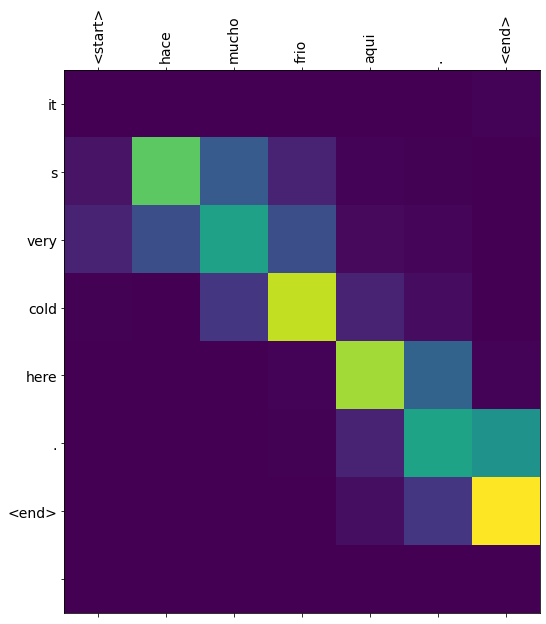

In [68]:
translate(u'hace mucho frio aqui.')

Input: <start> esta es mi vida . <end>
Predicted Translation: this is my life . <end> 


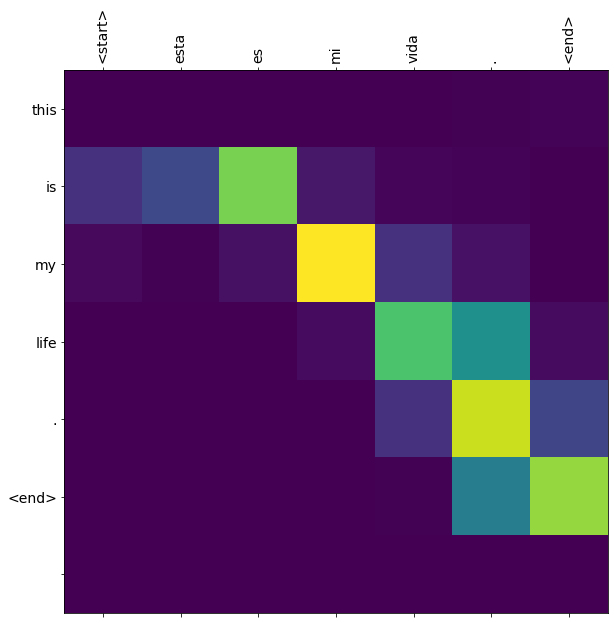

In [69]:
translate(u'esta es mi vida.')

Input: <start> ¿ todavia estan en casa ? <end>
Predicted Translation: are you still at home ? <end> 


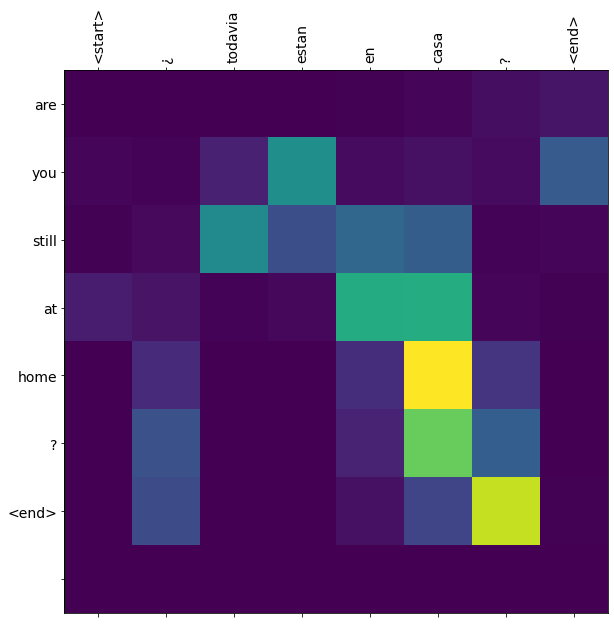

In [70]:
translate(u'¿todavia estan en casa?')


Input: <start> trata de averiguarlo . <end>
Predicted Translation: try to find out . <end> 


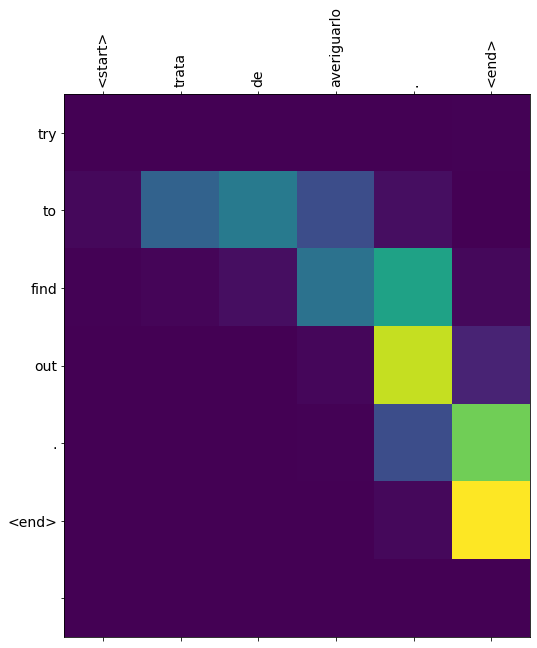

In [71]:
# Wrong translation by model
# Correct translation: try to find out . <end>
translate(u'trata de averiguarlo.')